DATASET DOWNLOAD AND EXTRACT

In [1]:
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from utility import plot_confusion_matrix
import tensorflow.keras.layers as layer
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [2]:
seed = 1231829
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
from data_loader import get_data
X_data, labels = get_data()

/Users/denisderonjic/Repos/ActivityRecognition/data_loader.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (np.array(X_data), labels)


In [4]:
print(X_data.shape)
print(labels.shape)

(761,)
(761,)


In [5]:
from data_transformation import frame_data

X_data, y_data = frame_data(X_data, labels)

In [6]:
X_data = X_data[:,:, :6] #Dropping magnetometer

In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

y_data = le.fit_transform(y_data)

In [8]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

num_labels = len(le_name_mapping)
print(num_labels)

{'FALLING': 0, 'JUMPING': 1, 'RUNNING': 2, 'SITTING': 3, 'STNDING': 4, 'WALKING': 5, 'XLYINGX': 6}
7


In [9]:
from data_transformation import data_normalization

X_data = data_normalization(X_data)

2021-09-14 16:38:42.142896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-14 16:38:42.143036: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
def plot_signal(signal):
    fig, axs = plt.subplots(2, 3)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    axs[0, 0].plot(signal[:,0], 'tab:red')
    axs[0, 0].set_title('Acc x')
    axs[0, 1].plot(signal[:,1], 'tab:blue')
    axs[0, 1].set_title('Acc y')
    axs[0, 2].plot(signal[:,2], 'tab:green')
    axs[0, 2].set_title('Acc z')

    axs[1, 0].plot(signal[:,3], 'tab:red')
    axs[1, 0].set_title('Gyro x')
    axs[1, 1].plot(signal[:,4], 'tab:blue')
    axs[1, 1].set_title('Gyro y')
    axs[1, 2].plot(signal[:,5], 'tab:green')
    axs[1, 2].set_title('Gyro z')

In [12]:
encoded_space_dim = 64
signal_dimension = X_data.shape[-1]

encoder = tf.keras.models.load_model('models/best_SSAE_model_encoder.h5', compile=False)

decoder = tf.keras.models.load_model('models/best_SSAE_model_decoder.h5', compile=False)

classifier = tf.keras.models.load_model('models/best_SSAE_model_classifier.h5', compile=False)

In [13]:
from models import SSAE
autoencoder = SSAE(encoded_space_dim, encoder, decoder, classifier, alpha=0.1, beta=1.0)

autoencoder.predict(X_data[:10]).shape
autoencoder(X_data[:10]).shape

TensorShape([10, 128, 6])

In [14]:
X_trans = autoencoder(X_data[:1000])

In [40]:
def plot_reconstructions(original, reconstruction):
    fig, axs = plt.subplots(3, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    axs[0, 0].plot(original[:,0], 'tab:red')
    axs[0, 0].set_title('Real Acc x')
    axs[0, 1].plot(reconstruction[:,0], 'tab:red')
    axs[0, 1].set_title('Pred Acc x')

    axs[1, 0].plot(original[:,1], 'tab:green')
    axs[1, 0].set_title('Real Acc y')
    axs[1, 1].plot(reconstruction[:,1], 'tab:green')
    axs[1, 1].set_title('Pred Acc y')

    axs[2, 0].plot(original[:,2], 'tab:blue')
    axs[2, 0].set_title('Real Acc 1')
    axs[2, 1].plot(reconstruction[:,2], 'tab:blue')
    axs[2, 1].set_title('Pred Acc 1')

Real:FALLING
Predicted: STNDING


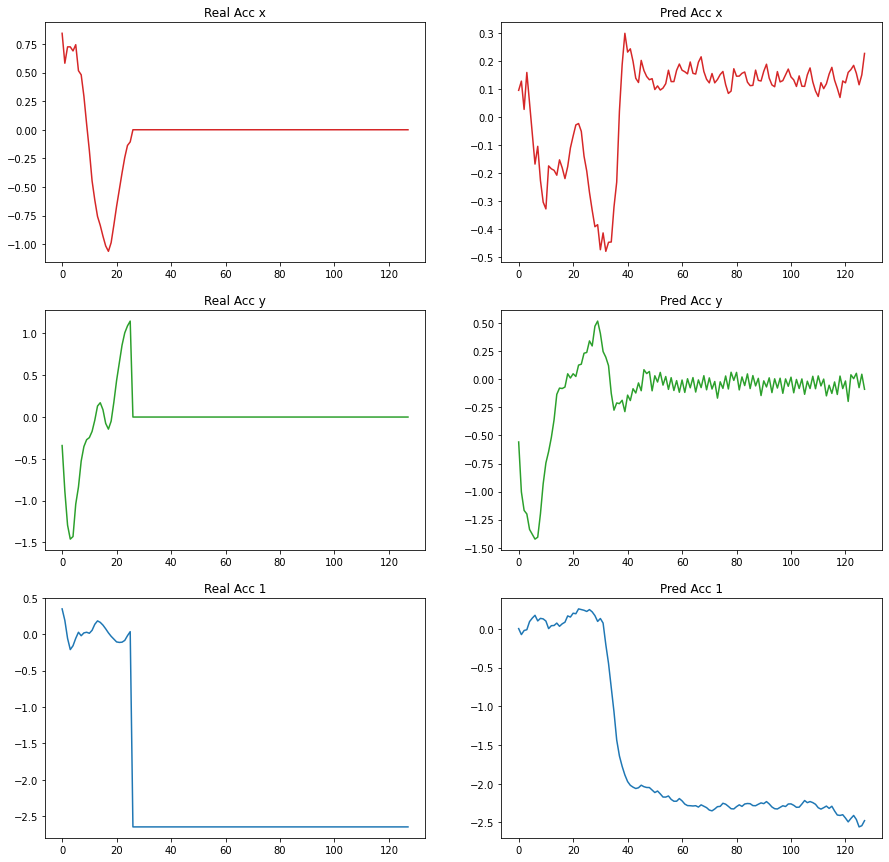

Real:JUMPING
Predicted: JUMPING


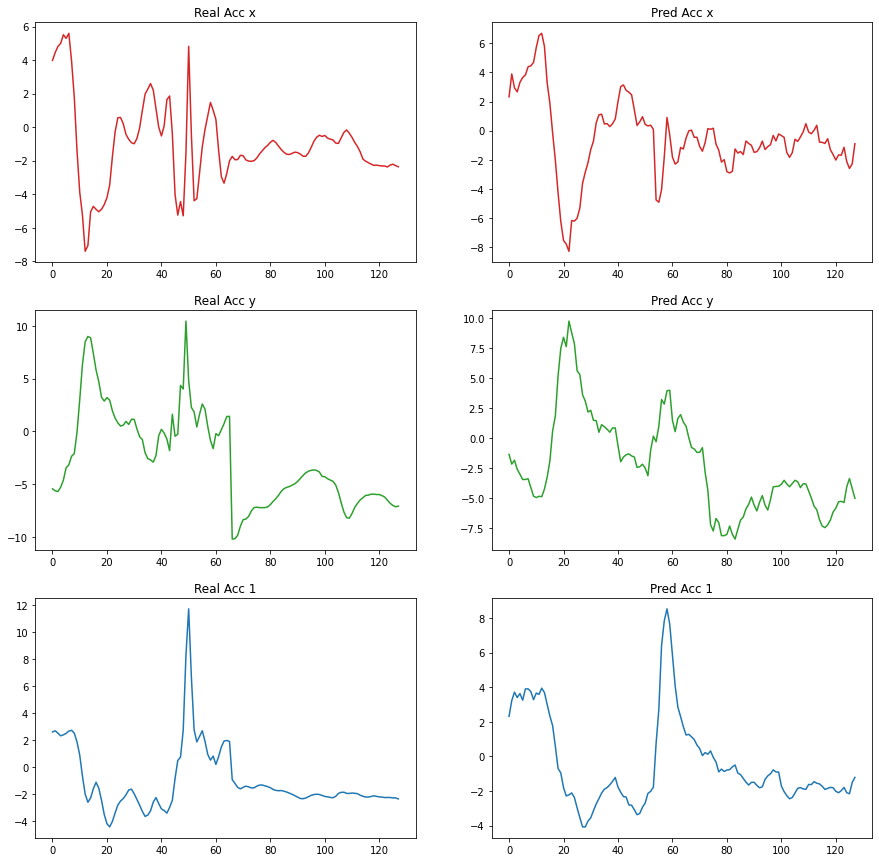

Real:RUNNING
Predicted: RUNNING


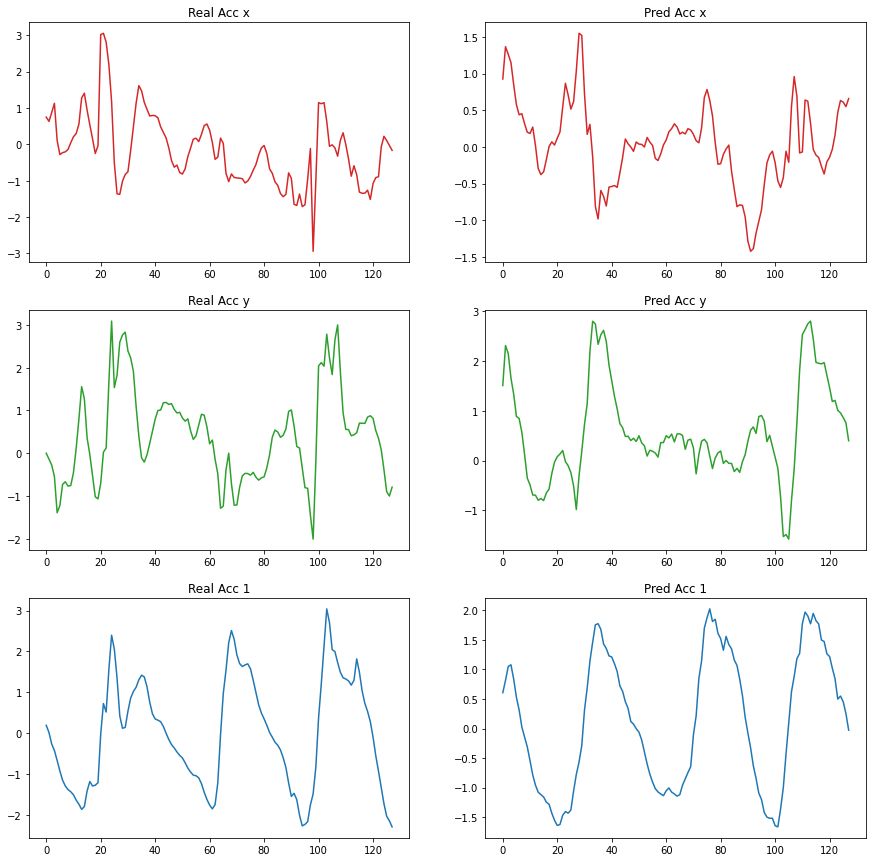

Real:SITTING
Predicted: SITTING


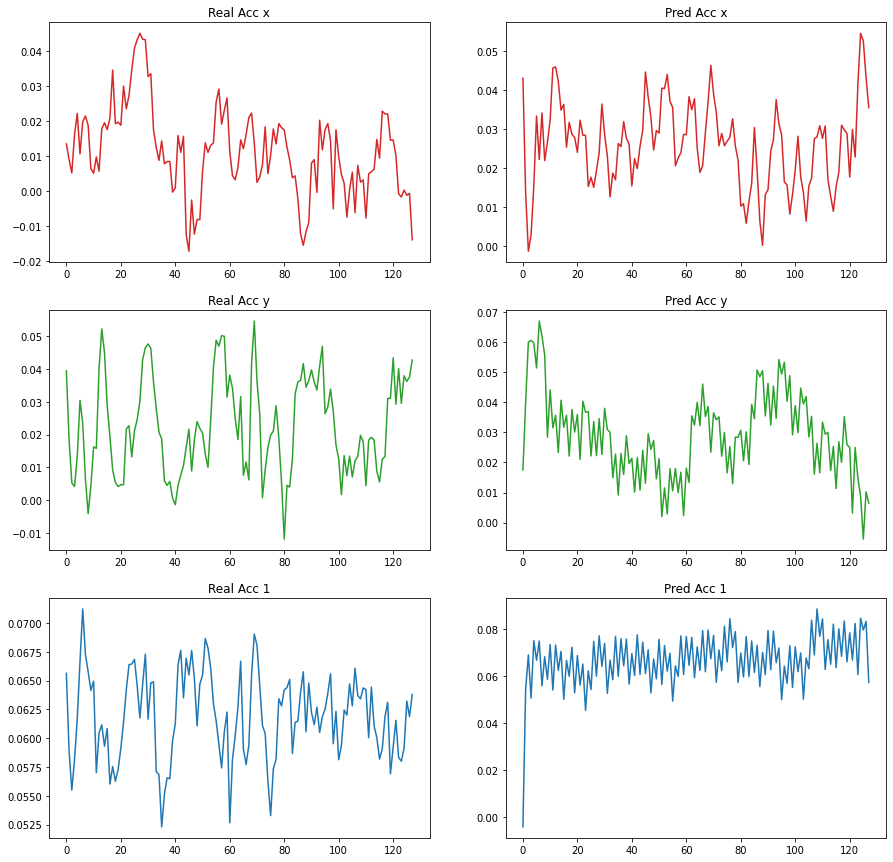

Real:STNDING
Predicted: STNDING


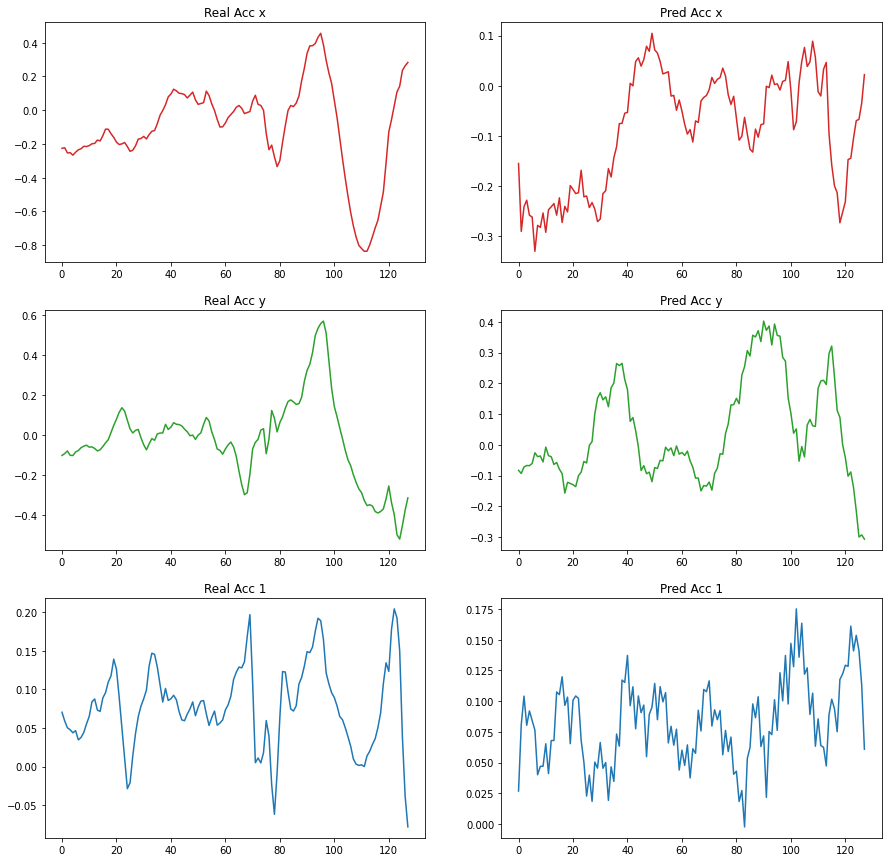

Real:WALKING
Predicted: WALKING


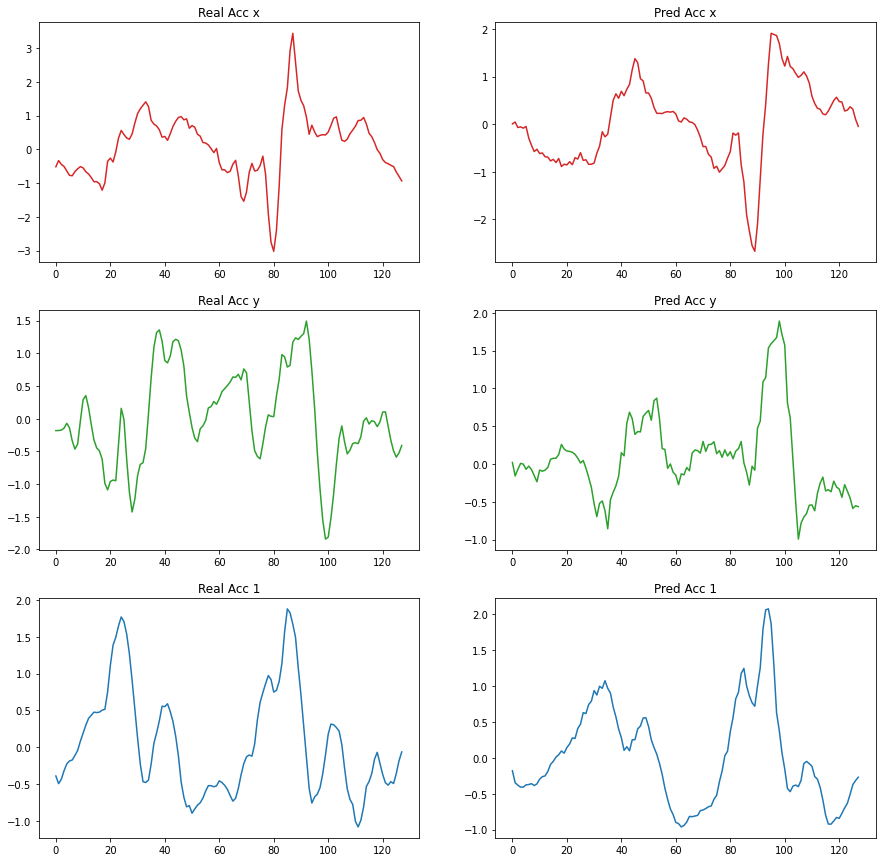

Real:XLYINGX
Predicted: XLYINGX


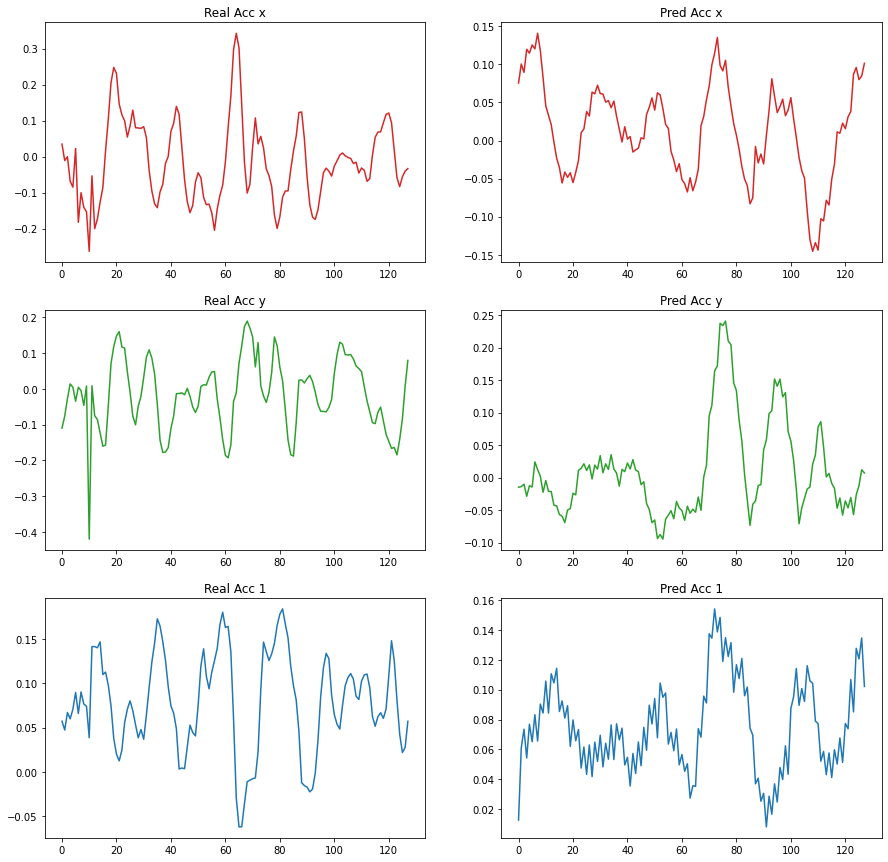

In [72]:
indexes = np.random.choice(X_data.shape[0], 1, replace=False)  

for label in range(7): #7 labels
    X = X_data[y_data == label]
    index = np.random.choice(X.shape[0], 1, replace=False)[0]
    X_rec = autoencoder(X[index-1:index])[0]
    print("Real:" + le.inverse_transform([label])[0])
    predicted = np.argmax(autoencoder.predict(X[index-1:index]),axis=1)[0]
    print("Predicted: " + le.inverse_transform([predicted])[0])
    plot_reconstructions(X[index], X_rec)
    plt.show()


In [73]:
### Get the encoded representation of the test samples
test_dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data)).shuffle(10000).batch(1000)
encoded_samples = []
labels = []
for sample, label in test_dataset:
    output = autoencoder.encode(sample)
    
    # Append to list
    encoded = output.numpy()
    for i in range(len(encoded)):
      enc = encoded[i]
      lbl = label[i]
      encoded_samples.append(enc)
      labels.append(lbl)
    if len(encoded_samples) % 10000 == 0:
      break
labels = np.array(labels)

In [75]:
labels = le.inverse_transform(labels) 

In [76]:
y_pred = autoencoder.predict(X_data)
y_pred = np.argmax(y_pred, axis=1)

In [83]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_pred, y_data)

accuracy = np.trace(conf_mat) / np.sum(conf_mat)

print(f"Accuracy: {accuracy * 100:.2f} %")

Accuracy: 97.34 %


In [87]:
from sklearn.metrics import precision_score, recall_score

#None, 'micro', 'macro', 'weighted'
precisions = precision_score(y_data, y_pred, average=None)
recalls = recall_score(y_data, y_pred, average=None)

for i in range(num_labels):
    print(le.inverse_transform([i])[0]+": Precision " + str(precisions[i]) + " Recall " + str(recalls[i]))


FALLING: Precision 0.8747315676449535 Recall 0.8539482879105521
JUMPING: Precision 0.9935884981542646 Recall 0.9187926697808121
RUNNING: Precision 0.9957489146164978 Recall 0.9921593366979091
SITTING: Precision 0.9365675740997078 Recall 0.982392256280249
STNDING: Precision 0.9827329050022946 Recall 0.9687397505061129
WALKING: Precision 0.9912748609311895 Recall 0.9981584500287742
XLYINGX: Precision 0.9588091353996737 Recall 0.9242714629711534


In [88]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_data, y_pred, average=None)
for i in range(num_labels):
    print(le.inverse_transform([i])[0]+": F1-score " + str(f1_scores[i]))

FALLING: F1-score 0.8642149929278642
JUMPING: F1-score 0.954727900681415
RUNNING: F1-score 0.9939508847959552
SITTING: F1-score 0.9589327694228541
STNDING: F1-score 0.9756861583674585
WALKING: F1-score 0.9947047466116113
XLYINGX: F1-score 0.9412235706242962


In [89]:
import matplotlib.cm

def plot_confusion_matrix(predictions, labels, target_names):

  '''
  ============================
  Internal function definition
  ============================
  '''
  def _confusion_matrix(cm,
                            target_names,
                            title='Confusion matrix',
                            cmap=None):
      import itertools

      accuracy = np.trace(cm) / float(np.sum(cm))
      misclass = 1 - accuracy

      if cmap is None:
          cmap = plt.get_cmap('Reds')
      
      cm = cm.astype('float')
      for i in range(len(cm)):
        cm[i] /= float(np.sum(cm[i]))

      plt.figure(figsize=(16, 12))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()

      if target_names is not None:
          tick_marks = np.arange(len(target_names))
          plt.xticks(tick_marks, target_names, rotation=45)
          plt.yticks(tick_marks, target_names)


      thresh = cm.max() / 2
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
              


      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
      plt.show()
  '''
  ===================================
  End of internal function definition
  ===================================
  '''

  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(predictions, labels)
  _confusion_matrix(conf_mat, target_names=target_names)

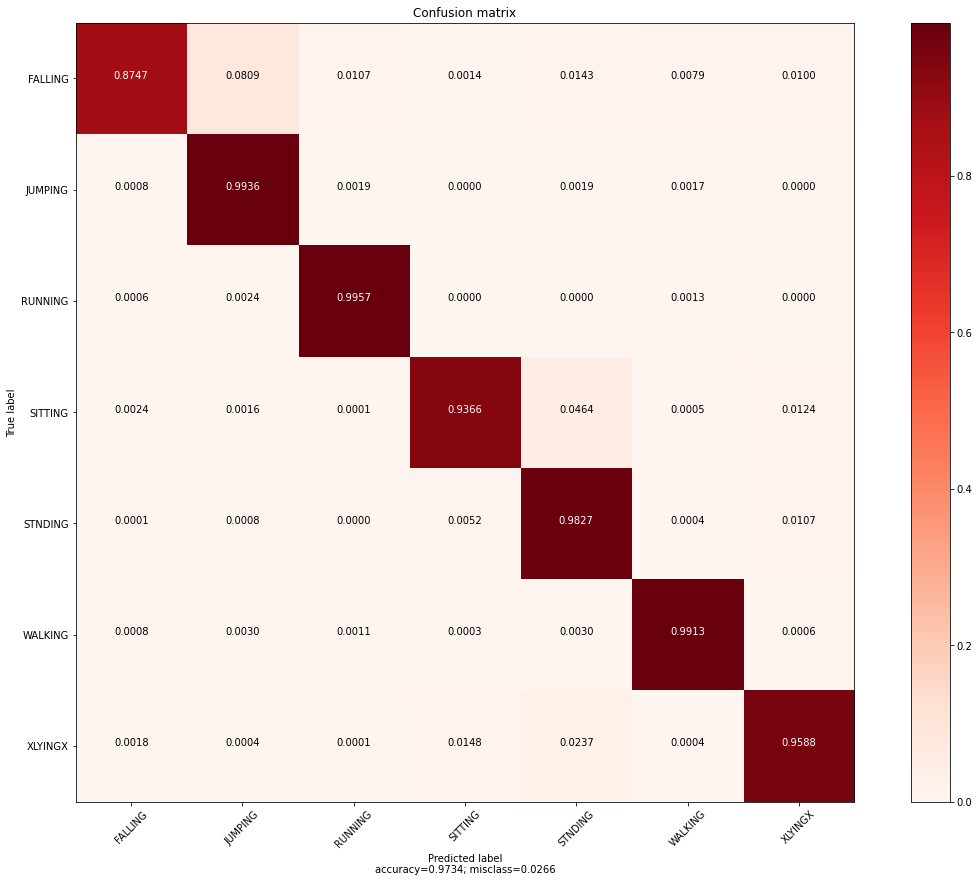

In [90]:
plot_confusion_matrix(y_pred, y_data, target_names=le.classes_)